In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    f1_score,
    matthews_corrcoef,
)
import shap
from scipy.stats import chi2

import os
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.tree import DecisionTreeClassifier, plot_tree


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

import warnings
from sklearn.covariance import MinCovDet
from scipy.spatial import distance
from typing import Dict, Optional, List


In [ ]:
# 1. Load
train = pd.read_csv("data/train_filtered.txt", sep="\t", na_values=["999", "999.0", 999, 999.0])
test  = pd.read_csv("data/test_filtered.txt",  sep="\t", na_values=["999", "999.0", 999, 999.0])
leb_data  = pd.read_csv("data/lebanese_BRCA1.txt",  sep="\t", na_values=["999", "999.0", 999, 999.0])

vus = pd.read_csv("data/vus_BRCA1_2.txt", sep="\t", na_values=["999", "999.0", 999, 999.0])

# uncomment for ablation results
# to_drop = ["id", "label", "Consequence", "CADD_RAW", "CADD_PHRED"]
to_drop = ["id", "label"]
features = [x for x in train.columns if x not in to_drop]   

X_train_benign = leb_data[leb_data["label"] == 0]
X_test_pathogenic = leb_data[leb_data["label"] == 1]

X_train_benign = X_train_benign[features]
X_test_pathogenic = X_test_pathogenic[features]

train_filtered = train[features].copy()
test_filtered  = test[features].copy()

X_train = train_filtered[features]
y_train = train["label"]

X_test = test_filtered[features]
y_test  = test ["label"]

vus_test = vus[features].copy()

In [173]:
X_train.replace("999", np.nan, inplace=True)
X_test.replace("999", np.nan, inplace=True)
vus_test.replace("999", np.nan, inplace=True)
X_train_benign.replace("999", np.nan, inplace=True)
X_test_pathogenic.replace("999", np.nan, inplace=True)

In [174]:
X_train.fillna(X_train.median(), inplace=True)
X_test. fillna(X_train.median(), inplace=True)
vus_test.fillna(X_train.median(), inplace=True)
X_train_benign.fillna(X_train.median(), inplace=True)
X_test_pathogenic.fillna(X_train.median(), inplace=True)

In [175]:
print(f"Selected Features: {len(X_train.columns)}")

Selected Features: 51


label
0     874
1    1794
Name: count, dtype: int64


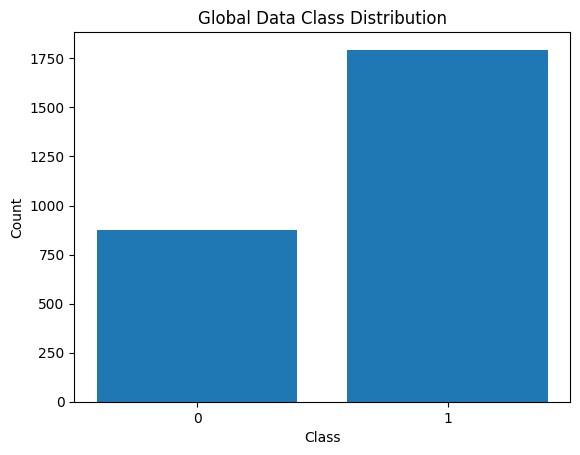

In [176]:
class_counts = y_train.value_counts().sort_index()
print(class_counts)

plt.bar(class_counts.index, class_counts.values)
plt.xticks([0, 1])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Global Data Class Distribution")
plt.show()

### Training

In [177]:
class CorrelationFilter(BaseEstimator, TransformerMixin):
    # we drop one of any pair of features whose abs(corr) > threshold
    def __init__(self, threshold=0.98):
        self.threshold = threshold

    def fit(self, X, y=None):
        df = pd.DataFrame(X)
        corr = df.corr().abs()
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        self.to_drop_ = [i for i in range(upper.shape[1]) 
                         if (upper.iloc[:, i] > self.threshold).any()]
        return self

    def transform(self, X):
        return np.delete(X, self.to_drop_, axis=1)

In [178]:
preprocessor = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("var_thresh", VarianceThreshold(threshold=1e-5)),
    ("corr_filter", CorrelationFilter(threshold=0.98)),
    ("scaler", StandardScaler()),
])

In [179]:
def _resolved_feature_names_after_preproc(preproc, X, feature_names: Optional[List[str]]):
    n_features = X.shape[1]
    names = list(feature_names) if feature_names is not None else [f"f{i}" for i in range(n_features)]

    vt = preproc.named_steps.get("var_thresh", None)
    cf = preproc.named_steps.get("corr_filter", None)

    if vt is not None and hasattr(vt, "get_support"):
        keep_idx_vt = vt.get_support(indices=True)
        names = [names[i] for i in keep_idx_vt]

    if cf is not None and hasattr(cf, "to_drop_"):
        to_drop = set(cf.to_drop_)
        names = [n for i, n in enumerate(names) if i not in to_drop]

    return names


def _print_logistic_importance(clf, final_names, top_k=10, title_prefix="Logistic"):
    coefs = clf.coef_.ravel()
    order = np.argsort(np.abs(coefs))[::-1][:top_k]
    rows = []
    
    for i in order:
        sign = "+" if coefs[i] >= 0 else "-"
        rows.append((final_names[i], float(coefs[i]), sign))
        
    print(f"\n[{title_prefix}] Top {top_k} features by |coef| (with sign):")
    
    for name, coef, sign in rows:
        print(f"  {name:<30s} {sign}{abs(coef):.4f}")


def _print_tree_importance(clf, final_names, top_k=10, title_prefix="Tree"):
    if hasattr(clf, "feature_importances_"):
        imps = clf.feature_importances_
        order = np.argsort(imps)[::-1][:top_k]
        print(f"\n[{title_prefix}] Top {top_k} features by impurity importance:")
        for i in order:
            print(f"  {final_names[i]:<30s} {imps[i]:.6f}")


def _xgb_shap_importance(clf, X_trans, final_names, top_k=10):
    explainer = shap.TreeExplainer(clf)
    shap_vals = explainer.shap_values(X_trans)

    if isinstance(shap_vals, list):
        shap_vals = shap_vals[0]

    mean_abs = np.mean(np.abs(shap_vals), axis=0)
    order = np.argsort(mean_abs)[::-1][:top_k]
    rows = [(final_names[i], float(mean_abs[i])) for i in order]
    return rows


def cross_validate_models(
    pipelines: Dict[str, object],
    X_train: np.ndarray, y_train: np.ndarray,
    X_test: np.ndarray, y_test: np.ndarray,
    vus_test: Optional[np.ndarray] = None,
    feature_names: Optional[List[str]] = None,
    n_folds: int = 5,
    random_state: int = 0,
    output_dir: Optional[str] = None,
    n_jobs: int = -1
):
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)

    scoring = {
        "accuracy": "accuracy",
        "mcc": "matthews_corrcoef",
        "roc_auc": "roc_auc",
        "precision": "precision",
        "recall": "recall",
        "f1": "f1",
    }

    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)

    for name, pipe in pipelines.items():
        print("\n" + "=" * 80)
        print(f"{name.upper()} — Stratified {n_folds}-fold CV")

        cv_results = cross_validate(
            pipe, X_train, y_train,
            cv=kf,
            scoring=scoring,
            return_train_score=True,
            n_jobs=n_jobs,
            error_score="raise"
        )

        def _m(metric):
            return np.mean(cv_results[f"test_{metric}"]), np.std(cv_results[f"test_{metric}"])

        def _mtr(metric):
            return np.mean(cv_results[f"train_{metric}"]), np.std(cv_results[f"train_{metric}"])

        print(" Train:")
        for m in ["accuracy", "mcc", "roc_auc", "precision", "recall", "f1"]:
            mean_, std_ = _mtr(m)
            print(f"  {m:<10s} {mean_:.4f} ± {std_:.4f}")

        print(" Valid:")
        for m in ["accuracy", "mcc", "roc_auc", "precision", "recall", "f1"]:
            mean_, std_ = _m(m)
            print(f"  {m:<10s} {mean_:.4f} ± {std_:.4f}")

        pipe_fit = clone(pipe)
        pipe_fit.fit(X_train, y_train)

        y_pred = pipe_fit.predict(X_test)
        if hasattr(pipe_fit, "predict_proba"):
            y_prob = pipe_fit.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_prob)
        else:
            y_prob = None
            auc = np.nan

        test_metrics = {
            "accuracy": accuracy_score(y_test, y_pred),
            "mcc": matthews_corrcoef(y_test, y_pred),
            "roc_auc": auc,
            "precision": precision_score(y_test, y_pred, zero_division=0),
            "recall": recall_score(y_test, y_pred, zero_division=0),
            "f1": f1_score(y_test, y_pred, zero_division=0),
        }
        print("\n Test (held‑out):")
        for k, v in test_metrics.items():
            print(f"  {k:<10s} {v:.4f}")

        # === Feature importance / interpretability ===
        
        # this allows me to test models without preprocessing to see difference
        if "preproc" in pipe_fit.named_steps:
            preproc = pipe_fit.named_steps["preproc"]
            final_names = _resolved_feature_names_after_preproc(preproc, X_train, feature_names)
            Xtr_trans = preproc.transform(X_train)
        else:
            # No preproc step
            final_names = feature_names or [f"f{i}" for i in range(X_train.shape[1])]
            Xtr_trans = X_train

        clf = pipe_fit.named_steps.get("clf")

        if isinstance(clf, LogisticRegression):
            _print_logistic_importance(clf, final_names, top_k=10, title_prefix="LogisticRegression")

        if isinstance(clf, XGBClassifier):
            rows = _xgb_shap_importance(clf, Xtr_trans, final_names, top_k=10)
            print("\n[XGBoost] Top 10 features by mean |SHAP|:")
            for name_i, val in rows:
                print(f"  {name_i:<30s} {val:.6f}")

        if isinstance(clf, DecisionTreeClassifier):
            _print_tree_importance(clf, final_names, top_k=10, title_prefix="DecisionTree")
            if output_dir:
                fig = plt.figure(figsize=(18, 10))
                plot_tree(
                    clf,
                    feature_names=final_names,
                    class_names=["Benign", "Pathogenic"],
                    filled=True,
                    impurity=True,
                    rounded=True
                )
                out_path = os.path.join(output_dir, f"{name}_tree.png")
                fig.tight_layout()
                fig.savefig(out_path, dpi=200)
                plt.close(fig)
                print(f"  [Saved tree plot] {out_path}")

        if vus_test is not None:
            try:
                vus_preds = pipe_fit.predict(vus_test)
                if hasattr(pipe_fit, "predict_proba"):
                    vus_probs = pipe_fit.predict_proba(vus_test)[:, 1]
                else:
                    vus_probs = None
                print("\n VUS predictions:", vus_preds)
                if vus_probs is not None:
                    print(" VUS probabilities:", vus_probs)
            except Exception as e:
                print(f"\n [WARN] VUS inference failed for {name}: {e}")


In [180]:
pipelines = {
    "xgboost": Pipeline([
        ("preproc", preprocessor),
        
        ("clf", XGBClassifier(
			booster="gbtree",
			objective="binary:logistic",
			learning_rate=0.3,
			max_depth=3,
			min_child_weight=1,
			subsample=1,
			colsample_bytree=1,
			n_estimators=100,
			eval_metric="logloss"
        )),
    ]),
    "logistic_linear": Pipeline([
        ("preproc", preprocessor),
        ("clf", LogisticRegression(
            penalty="l1",
            solver="liblinear",
			class_weight="balanced",
            C=1.0,
            max_iter=750,
            random_state=0
        )),
    ]),
    "decision_tree": Pipeline([
		("preproc", preprocessor),
		("clf", DecisionTreeClassifier(
				criterion="gini",
				max_depth=3,
				random_state=42
			)),
	])
}

In [181]:
cross_validate_models(
    pipelines=pipelines,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    vus_test=vus_test,                      # or None
    feature_names=list(features),         # original column names before preprocessing
    n_folds=5,
    random_state=0,
    output_dir="./model_outputs"            # to save tree plots (if any)
)



XGBOOST — Stratified 5-fold CV
 Train:
  accuracy   0.9996 ± 0.0002
  mcc        0.9991 ± 0.0004
  roc_auc    1.0000 ± 0.0000
  precision  0.9996 ± 0.0003
  recall     0.9999 ± 0.0003
  f1         0.9997 ± 0.0001
 Valid:
  accuracy   0.9959 ± 0.0022
  mcc        0.9906 ± 0.0050
  roc_auc    0.9991 ± 0.0017
  precision  0.9961 ± 0.0028
  recall     0.9978 ± 0.0021
  f1         0.9969 ± 0.0016

 Test (held‑out):
  accuracy   0.9970
  mcc        0.9934
  roc_auc    0.9999
  precision  1.0000
  recall     0.9954
  f1         0.9977

[XGBoost] Top 10 features by mean |SHAP|:
  Consequence                    6.442142
  CADD_PHRED                     1.403056
  Variant_length                 0.738886
  Variant_position               0.715901
  Maximum_allele_frequency       0.456855
  CADD_raw_rankscore             0.420278
  BayesDel_addAF_rankscore       0.264783
  Intron_number                  0.123293
  ClinPred_rankscore             0.079687
  Exon_number                    0.072829

 

In [182]:
print(f"Num pathogenic: {len(X_test_pathogenic)}")
print(f"Num benign: {len(X_train_benign)}")

Num pathogenic: 8
Num benign: 945


In [183]:
X_all = pd.concat([X_train_benign, X_test_pathogenic])
X_all = X_all.dropna(axis=1, how='all')              # Drop all-NaN columns
X_all = X_all.loc[:, X_all.nunique() > 1]            # Drop constant columns

In [184]:
X_all = X_all.fillna(X_all.median())

In [185]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)
X_train_scaled = X_scaled[:len(X_train_benign)]
X_test_scaled = X_scaled[len(X_train_benign):]

In [186]:
warnings.filterwarnings('ignore')

robust_cov = MinCovDet().fit(X_train_scaled)
mahal_scores = [
    distance.mahalanobis(x, robust_cov.location_, robust_cov.precision_)
    for x in X_test_scaled
]
print(mahal_scores)

[np.float64(65.84562585910211), np.float64(48.1953342927403), np.float64(67.8019583996733), np.float64(46.24999454641872), np.float64(66.02694120259221), np.float64(67.596862640732), np.float64(67.596862640732), np.float64(67.596862640732)]


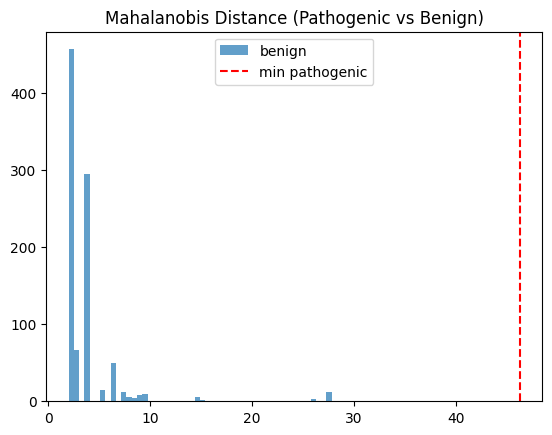

In [187]:
benign_mahal = [
    distance.mahalanobis(x, robust_cov.location_, robust_cov.precision_)
    for x in X_train_scaled
]

plt.hist(benign_mahal, bins=50, alpha=0.7, label="benign")
plt.axvline(min(mahal_scores), color='red', linestyle='--', label='min pathogenic')
plt.legend()
plt.title("Mahalanobis Distance (Pathogenic vs Benign)")
plt.show()

In [188]:
threshold = np.percentile(benign_mahal, 99.5)
print("Suggested threshold:", threshold)

anomalies = np.array(mahal_scores) > threshold
print("Detected pathogenic variants:", anomalies.sum())

Suggested threshold: 27.507905363144
Detected pathogenic variants: 8


In [189]:
df = X_test_scaled.shape[1]
mahal_sq = np.array(mahal_scores) ** 2
p_values = 1 - chi2.cdf(mahal_sq, df)

In [190]:
for i, (score, p) in enumerate(zip(mahal_scores, p_values)):
    print(f"Sample {i}: Mahalanobis={score:.2f}, p-value={p:.5f}")

Sample 0: Mahalanobis=65.85, p-value=0.00000
Sample 1: Mahalanobis=48.20, p-value=0.00000
Sample 2: Mahalanobis=67.80, p-value=0.00000
Sample 3: Mahalanobis=46.25, p-value=0.00000
Sample 4: Mahalanobis=66.03, p-value=0.00000
Sample 5: Mahalanobis=67.60, p-value=0.00000
Sample 6: Mahalanobis=67.60, p-value=0.00000
Sample 7: Mahalanobis=67.60, p-value=0.00000


## Anomaly Detection Inference on Lebanese VUS

In [191]:
common_cols = X_train_benign.columns.intersection(vus_test.columns)
vus_test = vus_test[common_cols]
X_train_sub = X_train_benign[common_cols]

X_all = pd.concat([X_train_sub, vus_test], axis=0)

X_all = X_all.dropna(axis=1, how='all')
X_all = X_all.loc[:, X_all.nunique() > 1]

X_all = X_all.fillna(X_all.median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)
X_train_scaled = X_scaled[:len(X_train_sub)]
X_vus_scaled = X_scaled[len(X_train_sub):]

robust_cov = MinCovDet().fit(X_train_scaled)

mahal_scores_vus = [
    distance.mahalanobis(x, robust_cov.location_, robust_cov.precision_)
    for x in X_vus_scaled
]

anomalous_flags = np.array(mahal_scores_vus) > threshold

# Create annotated DataFrame
vus_results = pd.DataFrame({
    "Mahalanobis_score": mahal_scores_vus,
    "Predicted_anomaly": anomalous_flags
})

print(vus_results.sort_values("Mahalanobis_score", ascending=False).head())

   Mahalanobis_score  Predicted_anomaly
0           3.169905              False
1           1.717319              False
